In [32]:
"""
File that runs the actual reconstruction optimizer forward pass. 
It should compute 3 loss functions: contour chamfer loss, tip distance 
loss, and motion model loss. In its forward pass, it will call upon 
the construction_bezier and motion_catheter scripts to build its 
catheters. It will be optimizing the parameter para_init. 
"""
import sys
sys.path.append('..')
sys.path.insert(1, 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts')

import torch
import torch.nn as nn
import cv2
# from tqdm.notebook import tqdm
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

from construction_bezier import ConstructionBezier
from loss_define import (
    ContourChamferLoss, 
    TipDistanceLoss, 
    ImageContourChamferLoss, 
    GenerateRefData
)

from catheter_motion import CatheterMotion


class ReconstructionOptimizer(nn.Module): 

    def __init__(self, p_start, para_init, image_ref, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list): 
        '''
        This function initializes the catheter optimization model.

        Args:
            p_start (tensor): starting point of the catheter
            image_ref (numpy array): reference image to compare to
            gpu_or_cpu (str): either 'cuda' or 'cpu'
        '''
        super().__init__()

        self.build_bezier = ConstructionBezier(radius=0.0015)
        self.build_bezier.to(gpu_or_cpu)
        self.build_bezier.loadRawImage(img_save_path)

        self.contour_chamfer_loss = ContourChamferLoss(device=gpu_or_cpu)
        self.contour_chamfer_loss.to(gpu_or_cpu)
        self.tip_distance_loss = TipDistanceLoss(device=gpu_or_cpu)
        self.tip_distance_loss.to(gpu_or_cpu)
        self.image_contour_chamfer_loss = ImageContourChamferLoss(device=gpu_or_cpu)
        self.image_contour_chamfer_loss.to(gpu_or_cpu)
        
        # Declare self.tip_euclidean_distance_loss as a variable that'll hold a single numpy scalar value
        self.tip_euclidean_distance_loss = None
        self.tip_loss = None

        self.p_start = p_start.to(gpu_or_cpu).detach()
        self.para_init = nn.Parameter(torch.from_numpy(para_init).to(gpu_or_cpu),
                                      requires_grad=True)
        
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Generate reference data, so you don't need to generate it in every forward pass
        self.generate_ref_data = GenerateRefData(self.image_ref)
        ref_catheter_contour = self.generate_ref_data.get_raw_contour()
        # self.register_buffer('ref_catheter_contour', ref_catheter_contour)
        self.ref_catheter_contour = ref_catheter_contour
        ref_catheter_centerline = self.generate_ref_data.get_raw_centerline()
        # self.register_buffer('ref_catheter_centerline', ref_catheter_centerline)
        self.ref_catheter_centerline = ref_catheter_centerline
        
        # self.register_buffer('delta_u_list', delta_u_list)
        self.delta_u_list = delta_u_list
        # self.register_buffer('past_frames_list', past_frames_list)
        # self.register_buffer('image_save_path_list', image_save_path_list)
        self.image_save_path_list = image_save_path_list
        
        # Generate reference data for past frames
        contour_list = []
        centerline_list = []
        for image in past_frames_list:
            image = torch.from_numpy(image.astype(np.float32))
            generate_ref_data = GenerateRefData(image)
            ref_catheter_contour = generate_ref_data.get_raw_contour()
            ref_catheter_centerline = generate_ref_data.get_raw_centerline()
            contour_list.append(ref_catheter_contour)
            centerline_list.append(ref_catheter_centerline)
        # self.register_buffer('contour_list', torch.stack(contour_list))
        # self.register_buffer('centerline_list', torch.stack(centerline_list))
        self.contour_list = contour_list
        self.centerline_list = centerline_list
        
        self.gpu_or_cpu = gpu_or_cpu

    def forward(self, save_img_path): 
        '''
        Function to run forward pass of the catheter optimization model.
        Creates catheter model, gets projection onto 2d image, and calculates loss.

        Args:
            save_img_path (str): path to save the projection image to
        '''

        # print('hello')
        
        # Generate the Bezier curve cylinder mesh points
        self.build_bezier.getBezierCurveCylinder(self.p_start, self.para_init)

        # Get 2d projected Bezier Cylinder mesh points
        self.build_bezier.getCylinderMeshProjImg()

        # Get 2d projected Bezier centerline (position) points
        self.build_bezier.getBezierProjImg()

        loss_contour = self.contour_chamfer_loss(self.build_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.ref_catheter_contour.to(self.gpu_or_cpu))

        loss_tip_distance, self.tip_euclidean_distance_loss = self.tip_distance_loss(self.build_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.ref_catheter_centerline.to(self.gpu_or_cpu))
        
        p0 = self.p_start.detach().cpu().numpy()
        para_init = self.para_init.detach().cpu().numpy()
        catheterMotion = CatheterMotion(p0, r=0.0015)
        predicted_paras = catheterMotion.past_frames_prediction(self.delta_u_list, para_init)
        motion_model_loss = torch.tensor(0.0).to(self.gpu_or_cpu)
        for i in range(len(predicted_paras)):
            construction_bezier = ConstructionBezier()
            construction_bezier.to(self.gpu_or_cpu)
            construction_bezier.loadRawImage(self.image_save_path_list[i])
            construction_bezier.getBezierCurveCylinder(self.p_start, torch.from_numpy(predicted_paras[i]).to(self.gpu_or_cpu))
            construction_bezier.getCylinderMeshProjImg()
            construction_bezier.getBezierProjImg()
            # build_bezier.draw2DCylinderImage(self.past_frames_list[i], save_img_path_list[i])
            
            loss_contour_m = self.contour_chamfer_loss(construction_bezier.bezier_proj_img.to(self.gpu_or_cpu), self.contour_list[i].to(self.gpu_or_cpu))
             
            # motion_model_loss += loss_contour_m.to(self.gpu_or_cpu)
            
            loss_tip_distance_m, self.tip_loss = self.tip_distance_loss(construction_bezier.bezier_proj_centerline_img.to(self.gpu_or_cpu), self.centerline_list[i].to(self.gpu_or_cpu)) 
            weight_m = torch.tensor([1.0e-4, 1.0]).to(self.gpu_or_cpu)
            loss_m = loss_contour_m.to(self.gpu_or_cpu) * weight_m[0] + loss_tip_distance_m.to(self.gpu_or_cpu) * weight_m[1]
            motion_model_loss += loss_m.to(self.gpu_or_cpu)
            
        
        weight = torch.tensor([1.0e-4, 1.0, 1.0e-5]).to(self.gpu_or_cpu)
        # weight = torch.tensor([1.0e-5, 1.0, 1.0e-6]).to(self.gpu_or_cpu)
        loss = loss_contour.to(self.gpu_or_cpu) * weight[0] + loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        # loss = loss_tip_distance.to(self.gpu_or_cpu) * weight[1] + motion_model_loss * weight[2]
        
        self.build_bezier.draw2DCylinderImage(self.image_ref, save_img_path)


        print("-----------------------------------------------------------------")
        print("loss_contour: ", loss_contour)
        # print("loss_tip: ", loss_tip)
        # print("loss_boundary: ", loss_boundary)
        print("loss_tip_distance: ", loss_tip_distance)
        # print("loss_boundary_point_distance_loss: ", loss_boundary_point_distance_loss)
        print("motion_model_loss: ", motion_model_loss)
        print("loss: ", loss)
        print("-----------------------------------------------------------------")


        # TODO: Plot the loss

        return loss
    





In [ ]:
def process_image(img_save_path):
    img_ref_rgb = cv2.imread(img_save_path)
    img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    
    return img_ref_binary

In [34]:

if __name__ == '__main__':
    '''
    Main function to set up optimzer model and run the optimization loop
    '''

    ###========================================================
    ### 1) SET TO GPU OR CPU COMPUTING
    ###========================================================
    if torch.cuda.is_available():
        gpu_or_cpu = torch.device("cuda:0") 
        torch.cuda.set_device(gpu_or_cpu)
    else:
        gpu_or_cpu = torch.device("cpu")

    ###========================================================
    ### 2) VARIABLES FOR BEZIER CURVE CONSTRUCTION
    ###========================================================
    # para_init = torch.tensor([0.02, 0.002, 0.0, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.0])


    # Z axis + 0.1
    # para_init = torch.tensor([0.02, 0.002, 0.1, 0.01958988, 0.00195899, 0.09690406, -0.03142905, -0.0031429, 0.18200866], dtype=torch.float)
    # p_start = torch.tensor([0.02, 0.002, 0.1000])
        
    

    # p_start and para_init used for SRC presentation
    # ground truth: [ 0.02007997  0.00160014  0.1026283   0.02973628 -0.04668138  0.19240253]
    p_start = torch.tensor([0.02, 0.002, 0.000001]) # 0 here will cause NaN in draw2DCylinderImage, pTip
    # para_init = np.array([0.0365, 0.0036,  0.1202,  0.0056, -0.0166, 0.1645],
    #                  dtype=np.float32) # 0, converge
    para_init = np.array([0.03, 0.0055,  0.0702,  0.0206, -0.0306, 0.1845],
                     dtype=np.float32) # 1, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0306, 0.1815],
    #                  dtype=np.float32) # 2, converge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0186, -0.0266, 0.2115],
    #                  dtype=np.float32) # 3, diverge
    # para_init = np.array([0.03, 0.0055,  0.0702,  0.0226, -0.0506, 0.2115],
    #                  dtype=np.float32) # 4
    # para_init = np.array([0.03, 0.0055,  0.0802,  0.0226, -0.0406, 0.2115],
    #                  dtype=np.float32) # 5
    # para_init = np.array([0.0395, 0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.0395, -0.0066,  0.1502,  0.0006, -0.0066, 0.1045],
    #                  dtype=np.float32)
    # para_init = np.array([0.04, -0.0166,  0.2002,  -0.0006, -0.0266, 0.0345],
    #                  dtype=np.float32)
    # para_init = np.array([0.02, 0.002,  0.1,  0.03, -0.05, 0.2],
    #                  dtype=np.float32)

    # case_naming = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    # case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/blender_imgs/test_catheter_gt1'
    case_naming = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/dof2_c48_0.001_-0.005_0.2_0.01'
    img_save_path = case_naming + '.png'
    cc_specs_path = case_naming + '_gt.npy'
    target_specs_path = None
    viewpoint_mode = 1
    transparent_mode = 0

    '''
    Create binary mask of catheter: 
        1) Grayscale the ref img, 
        2) threshold the grayscaled img, 
        3) Creates a binary image by replacing all 
            pixel values equal to 255 with 1 (leaves
            other pixel values unchanged)
    '''
    # img_ref_rgb = cv2.imread(img_save_path)
    # img_ref_gray = cv2.cvtColor(img_ref_rgb, cv2.COLOR_BGR2GRAY)
    # (thresh, img_ref_thresh) = cv2.threshold(img_ref_gray, 80, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # img_ref_binary = np.where(img_ref_thresh == 255, 1, img_ref_thresh)
    img_ref_binary = process_image(img_save_path)

    # Declare loss history lists to keep track of loss values
    proj_end_effector_loss_history = []
    d3d_end_effector_loss_history = []
    # Ground Truth parameters for catheter used in SRC presentation
    para_gt_np = np.load(cc_specs_path)[1:3, :].flatten()
    para_gt = torch.tensor(para_gt_np, dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    # para_gt = torch.tensor([0.02003904, 0.0016096, 0.13205799, 0.00489567, -0.03695673, 0.196168896], dtype=torch.float, device=gpu_or_cpu, requires_grad=False)
    end_effector_gt = para_gt[3:6]
    
    folder_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/data/rendered_images/dof2_64/'
    image_save_path_list = [
    folder_path + 'dof2_c47_0.0005_0.005_0.2_0.01.png',
    folder_path + 'dof2_c46_0.0005_0.001_0.2_0.01.png',
    folder_path + 'dof2_c45_0.0005_0.0005_0.2_0.01.png',
    folder_path + 'dof2_c42_0.0005_-0.0005_0.2_0.01.png',
    folder_path + 'dof2_c40_0.0005_-0.005_0.2_0.01.png',
    folder_path + 'dof2_c39_0.0001_0.005_0.2_0.01.png',
    folder_path + 'dof2_c32_0.0001_-0.005_0.2_0.01.png',
    folder_path + 'dof2_c31_-0.0001_0.005_0.2_0.01.png',
    folder_path + 'dof2_c6_-0.005_0.001_0.2_0.01.png'
    ]
    
    past_frames_list = []
    for path in image_save_path_list:
        past_frames_list.append(process_image(path))
    
    delta_u_list = [[0.0005, -0.01], [0, 0.004], [0, 0.0005], [0, 0.001], [0, 0.0045], [0.0004, -0.01], [0, 0.01], [0.0002, -0.01], [0.0049, 0.004]]

    


    ###========================================================
    ### 3) SET UP AND RUN OPTIMIZATION MODEL
    ###========================================================
    catheter_optimize_model = ReconstructionOptimizer(p_start, para_init, img_ref_binary, gpu_or_cpu, past_frames_list, delta_u_list, img_save_path, image_save_path_list).to(gpu_or_cpu)

    print("Model Parameters:")
    for name, param in catheter_optimize_model.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")

    optimizer = torch.optim.Adam(catheter_optimize_model.parameters(), lr=1e-2)

    # Run the optimization loop
    num_iterations = 100
    loop = tqdm(range(num_iterations))
    for loop_id in loop:
        print("\n================================================================================================================")
        print("loop_id: ", loop_id)


        # save_img_path = '/Users/kobeyang/Downloads/Programming/ECESRIP/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs/' \
        #     + 'render_' + str(loop_id) + '.jpg'
            
        save_img_path = 'E:/OneDrive - UC San Diego/UCSD/Lab/Catheter/diff_catheter/scripts/test_diff_render_catheter_v2/rendered_imgs_new/' \
            + 'render_' + str(loop_id) + '.jpg'

        # pdb.set_trace()

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Run the forward pass
        loss = catheter_optimize_model(save_img_path)

        # Print gradients for all parameters before backward pass
        print("Gradients BEFORE BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")  # Print the norm of the gradient
            else:
                print(f"{name}: No gradient computed")

        # Run the backward pass
        loss.backward(retain_graph=True)

        # Print gradients for all parameters after backward pass
        print("Gradients AFTER BACKWARD PASS:")
        for name, param in catheter_optimize_model.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient: {param.grad.norm().item()}")
            else:
                print(f"{name}: No gradient computed")
                
        # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the parameters
        optimizer.step()


        # Print and inspect the updated parameters
        for name, param in catheter_optimize_model.named_parameters():
            print(f"Parameter: {name}, Updated Value: {param.data}")


        # # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
        # proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
        # d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

        # Update the progress bar
        loop.set_description('Optimizing')

        # Update the loss
        loop.set_postfix(loss=loss.item())

        print("Loss: ", loss.item())

    # end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())
    proj_end_effector_loss_history.append(catheter_optimize_model.tip_euclidean_distance_loss.item())
    d3d_end_effector_loss_history.append(torch.norm((catheter_optimize_model.para_init[3:6] - end_effector_gt), p=2).item())

    for name, param in catheter_optimize_model.named_parameters():
        param_numpy = param.data.cpu().numpy()
        filename = f"{name}.npy"
        np.save(filename, param_numpy)
        print(f"Saved {name} to {filename}")

Model Parameters:
para_init: requires_grad=True


  0%|          | 0/100 [00:00<?, ?it/s]


loop_id:  0
-----------------------------------------------------------------
loss_contour:  tensor(24389681.0979, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2981.3144, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(71715928., device='cuda:0')
loss:  tensor(6137.4417, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   1%|          | 1/100 [00:02<04:10,  2.53s/it, loss=6.14e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1686574.375
Parameter: para_init, Updated Value: tensor([ 0.0400,  0.0155,  0.0602,  0.0106, -0.0406,  0.1745], device='cuda:0')
Loss:  6137.44173229017

loop_id:  1
-----------------------------------------------------------------
loss_contour:  tensor(7246460.2237, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3428.3591, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.8388e+08, device='cuda:0')
loss:  tensor(5991.8057, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   2%|▏         | 2/100 [00:05<04:20,  2.66s/it, loss=5.99e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 387621.4375
Parameter: para_init, Updated Value: tensor([ 0.0466,  0.0228,  0.0523,  0.0130, -0.0469,  0.1645], device='cuda:0')
Loss:  5991.805663248625

loop_id:  2
-----------------------------------------------------------------
loss_contour:  tensor(4659874.1349, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2924.6055, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(56511284., device='cuda:0')
loss:  tensor(3955.7057, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   3%|▎         | 3/100 [00:08<04:33,  2.82s/it, loss=3.96e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 409372.5625
Parameter: para_init, Updated Value: tensor([ 0.0517,  0.0285,  0.0460,  0.0184, -0.0422,  0.1626], device='cuda:0')
Loss:  3955.705716917743

loop_id:  3
-----------------------------------------------------------------
loss_contour:  tensor(4076656.7752, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(767.8709, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(22175844., device='cuda:0')
loss:  tensor(1397.2950, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   4%|▍         | 4/100 [00:11<04:45,  2.98s/it, loss=1.4e+3] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 214197.984375
Parameter: para_init, Updated Value: tensor([ 0.0560,  0.0332,  0.0408,  0.0245, -0.0366,  0.1610], device='cuda:0')
Loss:  1397.2949905592823

loop_id:  4
-----------------------------------------------------------------
loss_contour:  tensor(4004948.6498, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(91.3159, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.3714e+09, device='cuda:0')
loss:  tensor(44205.6545, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   5%|▌         | 5/100 [00:14<04:55,  3.11s/it, loss=4.42e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 81345.40625
Parameter: para_init, Updated Value: tensor([ 0.0596,  0.0372,  0.0364,  0.0298, -0.0338,  0.1578], device='cuda:0')
Loss:  44205.654489030676

loop_id:  5
-----------------------------------------------------------------
loss_contour:  tensor(3972147.2700, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(788.7037, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.1502e+08, device='cuda:0')
loss:  tensor(2336.0837, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   6%|▌         | 6/100 [00:18<05:05,  3.25s/it, loss=2.34e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 221784.890625
Parameter: para_init, Updated Value: tensor([ 0.0627,  0.0406,  0.0327,  0.0328, -0.0344,  0.1552], device='cuda:0')
Loss:  2336.083736736386

loop_id:  6
-----------------------------------------------------------------
loss_contour:  tensor(4003207.1958, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1449.3461, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.3363e+09, device='cuda:0')
loss:  tensor(25212.6688, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   7%|▋         | 7/100 [00:22<05:19,  3.43s/it, loss=2.52e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 307826.90625
Parameter: para_init, Updated Value: tensor([ 0.0654,  0.0435,  0.0296,  0.0330, -0.0366,  0.1563], device='cuda:0')
Loss:  25212.66875170214

loop_id:  7
-----------------------------------------------------------------
loss_contour:  tensor(4112675.7812, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1295.7836, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(30580288., device='cuda:0')
loss:  tensor(2012.8541, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   8%|▊         | 8/100 [00:25<05:26,  3.55s/it, loss=2.01e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 291196.125
Parameter: para_init, Updated Value: tensor([ 0.0678,  0.0461,  0.0270,  0.0313, -0.0393,  0.1601], device='cuda:0')
Loss:  2012.8541020532093

loop_id:  8
-----------------------------------------------------------------
loss_contour:  tensor(4267499.4101, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(663.0461, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.7461e+08, device='cuda:0')
loss:  tensor(2835.8565, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:   9%|▉         | 9/100 [00:29<05:35,  3.69s/it, loss=2.84e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 203407.96875
Parameter: para_init, Updated Value: tensor([ 0.0699,  0.0485,  0.0249,  0.0285, -0.0414,  0.1654], device='cuda:0')
Loss:  2835.8565457457053

loop_id:  9
-----------------------------------------------------------------
loss_contour:  tensor(4492699.2032, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(154.7321, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(17871080., device='cuda:0')
loss:  tensor(782.7128, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  10%|█         | 10/100 [00:34<05:48,  3.87s/it, loss=783]   

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 92701.2265625
Parameter: para_init, Updated Value: tensor([ 0.0718,  0.0505,  0.0232,  0.0255, -0.0428,  0.1712], device='cuda:0')
Loss:  782.7128494077891

loop_id:  10
-----------------------------------------------------------------
loss_contour:  tensor(4836457.1363, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(32.5993, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.5530e+09, device='cuda:0')
loss:  tensor(36045.9910, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  11%|█         | 11/100 [00:38<06:01,  4.06s/it, loss=3.6e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 42744.87890625
Parameter: para_init, Updated Value: tensor([ 0.0735,  0.0523,  0.0221,  0.0230, -0.0436,  0.1766], device='cuda:0')
Loss:  36045.99104961745

loop_id:  11
-----------------------------------------------------------------
loss_contour:  tensor(5323749.8874, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(223.4787, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.9253e+08, device='cuda:0')
loss:  tensor(2681.1589, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  12%|█▏        | 12/100 [00:43<06:12,  4.24s/it, loss=2.68e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 120241.984375
Parameter: para_init, Updated Value: tensor([ 0.0751,  0.0540,  0.0216,  0.0216, -0.0442,  0.1808], device='cuda:0')
Loss:  2681.158871233916

loop_id:  12
-----------------------------------------------------------------
loss_contour:  tensor(5807562.3394, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(469.7393, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(99450496., device='cuda:0')
loss:  tensor(2045.0004, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  13%|█▎        | 13/100 [00:48<06:28,  4.47s/it, loss=2.05e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 177851.953125
Parameter: para_init, Updated Value: tensor([ 0.0766,  0.0554,  0.0217,  0.0214, -0.0450,  0.1834], device='cuda:0')
Loss:  2045.0004354290527

loop_id:  13
-----------------------------------------------------------------
loss_contour:  tensor(5855027.5482, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(555.3935, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(80704760., device='cuda:0')
loss:  tensor(1947.9438, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  14%|█▍        | 14/100 [00:53<06:37,  4.62s/it, loss=1.95e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 189176.75
Parameter: para_init, Updated Value: tensor([ 0.0780,  0.0567,  0.0223,  0.0223, -0.0459,  0.1848], device='cuda:0')
Loss:  1947.943847663376

loop_id:  14
-----------------------------------------------------------------
loss_contour:  tensor(5470669.7075, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(454.3638, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(22155636., device='cuda:0')
loss:  tensor(1222.9871, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  15%|█▌        | 15/100 [00:58<06:46,  4.78s/it, loss=1.22e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 160671.921875
Parameter: para_init, Updated Value: tensor([ 0.0794,  0.0578,  0.0232,  0.0240, -0.0466,  0.1853], device='cuda:0')
Loss:  1222.987134316124

loop_id:  15
-----------------------------------------------------------------
loss_contour:  tensor(5062082.9532, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(267.7634, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(6866212., device='cuda:0')
loss:  tensor(842.6338, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  16%|█▌        | 16/100 [01:04<06:59,  5.00s/it, loss=843]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 117794.4609375
Parameter: para_init, Updated Value: tensor([ 0.0806,  0.0588,  0.0245,  0.0262, -0.0467,  0.1854], device='cuda:0')
Loss:  842.6337983489927

loop_id:  16
-----------------------------------------------------------------
loss_contour:  tensor(4762374.9933, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(100.3498, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.5334e+09, device='cuda:0')
loss:  tensor(15910.2845, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  17%|█▋        | 17/100 [01:09<07:09,  5.18s/it, loss=1.59e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 69919.7734375
Parameter: para_init, Updated Value: tensor([ 0.0817,  0.0596,  0.0259,  0.0286, -0.0463,  0.1856], device='cuda:0')
Loss:  15910.28453283421

loop_id:  17
-----------------------------------------------------------------
loss_contour:  tensor(4557017.3838, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(20.5755, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0927e+09, device='cuda:0')
loss:  tensor(11402.8944, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  18%|█▊        | 18/100 [01:15<07:24,  5.42s/it, loss=1.14e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 28520.646484375
Parameter: para_init, Updated Value: tensor([ 0.0828,  0.0604,  0.0274,  0.0307, -0.0456,  0.1862], device='cuda:0')
Loss:  11402.894416699739

loop_id:  18
-----------------------------------------------------------------
loss_contour:  tensor(4413589.6793, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(49.4590, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(51188764., device='cuda:0')
loss:  tensor(1002.7056, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  19%|█▉        | 19/100 [01:21<07:28,  5.53s/it, loss=1e+3]   

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 44728.22265625
Parameter: para_init, Updated Value: tensor([ 0.0837,  0.0612,  0.0290,  0.0324, -0.0447,  0.1871], device='cuda:0')
Loss:  1002.7056166327214

loop_id:  19
-----------------------------------------------------------------
loss_contour:  tensor(4307550.0774, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(150.0631, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(18501356., device='cuda:0')
loss:  tensor(765.8316, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  20%|██        | 20/100 [01:27<07:38,  5.73s/it, loss=766] 

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 80345.2421875
Parameter: para_init, Updated Value: tensor([ 0.0845,  0.0618,  0.0306,  0.0335, -0.0443,  0.1885], device='cuda:0')
Loss:  765.8316420321685

loop_id:  20
-----------------------------------------------------------------
loss_contour:  tensor(4222659.0422, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(243.5159, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.3143e+10, device='cuda:0')
loss:  tensor(132099.7975, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  21%|██        | 21/100 [01:33<07:47,  5.91s/it, loss=1.32e+5]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 102343.1015625
Parameter: para_init, Updated Value: tensor([ 0.0853,  0.0624,  0.0323,  0.0339, -0.0444,  0.1902], device='cuda:0')
Loss:  132099.7974573737

loop_id:  21
-----------------------------------------------------------------
loss_contour:  tensor(4149467.3039, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(262.1989, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(12888375., device='cuda:0')
loss:  tensor(806.0294, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  22%|██▏       | 22/100 [01:40<07:54,  6.09s/it, loss=806]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 105348.40625
Parameter: para_init, Updated Value: tensor([ 0.0860,  0.0629,  0.0339,  0.0337, -0.0452,  0.1922], device='cuda:0')
Loss:  806.0294122399836

loop_id:  22
-----------------------------------------------------------------
loss_contour:  tensor(4083977.3624, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(198.4006, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(7242571., device='cuda:0')
loss:  tensor(679.2240, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  23%|██▎       | 23/100 [01:47<08:12,  6.40s/it, loss=679]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 90463.515625
Parameter: para_init, Updated Value: tensor([ 0.0866,  0.0634,  0.0355,  0.0330, -0.0464,  0.1944], device='cuda:0')
Loss:  679.2240258466578

loop_id:  23
-----------------------------------------------------------------
loss_contour:  tensor(4026128.9737, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(100.6571, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(55797496., device='cuda:0')
loss:  tensor(1061.2450, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  24%|██▍       | 24/100 [01:54<08:16,  6.53s/it, loss=1.06e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 63104.55859375
Parameter: para_init, Updated Value: tensor([ 0.0872,  0.0638,  0.0371,  0.0320, -0.0478,  0.1968], device='cuda:0')
Loss:  1061.2449898564023

loop_id:  24
-----------------------------------------------------------------
loss_contour:  tensor(3978298.8060, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(27.6362, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(31455480., device='cuda:0')
loss:  tensor(740.0209, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  25%|██▌       | 25/100 [02:01<08:22,  6.70s/it, loss=740]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 31261.611328125
Parameter: para_init, Updated Value: tensor([ 0.0877,  0.0642,  0.0386,  0.0308, -0.0491,  0.1992], device='cuda:0')
Loss:  740.0208654921005

loop_id:  25
-----------------------------------------------------------------
loss_contour:  tensor(3943010.4631, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(6.8992, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.1887e+08, device='cuda:0')
loss:  tensor(3589.8679, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  26%|██▌       | 26/100 [02:08<08:25,  6.84s/it, loss=3.59e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 14134.5498046875
Parameter: para_init, Updated Value: tensor([ 0.0882,  0.0646,  0.0401,  0.0298, -0.0501,  0.2016], device='cuda:0')
Loss:  3589.8679295153515

loop_id:  26
-----------------------------------------------------------------
loss_contour:  tensor(3921342.1004, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(28.3234, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(39989228., device='cuda:0')
loss:  tensor(820.3498, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  27%|██▋       | 27/100 [02:16<08:31,  7.01s/it, loss=820]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 33521.84765625
Parameter: para_init, Updated Value: tensor([ 0.0887,  0.0649,  0.0415,  0.0291, -0.0506,  0.2039], device='cuda:0')
Loss:  820.3498401527977

loop_id:  27
-----------------------------------------------------------------
loss_contour:  tensor(3910666.0934, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(64.4871, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.8040e+08, device='cuda:0')
loss:  tensor(2259.5931, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  28%|██▊       | 28/100 [02:24<08:50,  7.36s/it, loss=2.26e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 51195.703125
Parameter: para_init, Updated Value: tensor([ 0.0891,  0.0652,  0.0430,  0.0287, -0.0508,  0.2059], device='cuda:0')
Loss:  2259.593114232481

loop_id:  28
-----------------------------------------------------------------
loss_contour:  tensor(3903385.0744, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(91.3810, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(19239484., device='cuda:0')
loss:  tensor(674.1144, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  29%|██▉       | 29/100 [02:32<09:05,  7.68s/it, loss=674]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 61276.86328125
Parameter: para_init, Updated Value: tensor([ 0.0894,  0.0654,  0.0443,  0.0287, -0.0507,  0.2074], device='cuda:0')
Loss:  674.1143687460631

loop_id:  29
-----------------------------------------------------------------
loss_contour:  tensor(3887942.8042, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(96.1549, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.4267e+08, device='cuda:0')
loss:  tensor(2911.6440, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  30%|███       | 30/100 [02:41<09:18,  7.98s/it, loss=2.91e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 63344.4140625
Parameter: para_init, Updated Value: tensor([ 0.0898,  0.0656,  0.0457,  0.0292, -0.0506,  0.2085], device='cuda:0')
Loss:  2911.6440412550724

loop_id:  30
-----------------------------------------------------------------
loss_contour:  tensor(3855379.6192, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(77.3624, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(20743248., device='cuda:0')
loss:  tensor(670.3328, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  31%|███       | 31/100 [02:50<09:30,  8.26s/it, loss=670]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 57448.51953125
Parameter: para_init, Updated Value: tensor([ 0.0901,  0.0658,  0.0469,  0.0300, -0.0505,  0.2089], device='cuda:0')
Loss:  670.332846700461

loop_id:  31
-----------------------------------------------------------------
loss_contour:  tensor(3806203.7587, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44.2347, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(77922216., device='cuda:0')
loss:  tensor(1204.0772, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  32%|███▏      | 32/100 [02:58<09:25,  8.32s/it, loss=1.2e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 44243.22265625
Parameter: para_init, Updated Value: tensor([ 0.0904,  0.0660,  0.0482,  0.0310, -0.0506,  0.2090], device='cuda:0')
Loss:  1204.077211498106

loop_id:  32
-----------------------------------------------------------------
loss_contour:  tensor(3750151.1594, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(13.4047, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.6221e+08, device='cuda:0')
loss:  tensor(5010.4989, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  33%|███▎      | 33/100 [03:07<09:24,  8.42s/it, loss=5.01e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 25533.7890625
Parameter: para_init, Updated Value: tensor([ 0.0907,  0.0661,  0.0494,  0.0321, -0.0507,  0.2088], device='cuda:0')
Loss:  5010.498865540487

loop_id:  33
-----------------------------------------------------------------
loss_contour:  tensor(3698828.5329, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1858, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(13142571., device='cuda:0')
loss:  tensor(501.4944, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  34%|███▍      | 34/100 [03:16<09:27,  8.60s/it, loss=501]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4650.25390625
Parameter: para_init, Updated Value: tensor([ 0.0910,  0.0663,  0.0505,  0.0331, -0.0508,  0.2086], device='cuda:0')
Loss:  501.49435612589684

loop_id:  34
-----------------------------------------------------------------
loss_contour:  tensor(3659144.3320, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.5047, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(80251704., device='cuda:0')
loss:  tensor(1176.9362, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  35%|███▌      | 35/100 [03:25<09:28,  8.75s/it, loss=1.18e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 15914.208984375
Parameter: para_init, Updated Value: tensor([ 0.0912,  0.0664,  0.0516,  0.0339, -0.0509,  0.2087], device='cuda:0')
Loss:  1176.936185925817

loop_id:  35
-----------------------------------------------------------------
loss_contour:  tensor(3631787.8714, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(28.4225, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(21470286., device='cuda:0')
loss:  tensor(606.3041, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  36%|███▌      | 36/100 [03:34<09:29,  8.90s/it, loss=606]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 31109.880859375
Parameter: para_init, Updated Value: tensor([ 0.0914,  0.0665,  0.0527,  0.0344, -0.0509,  0.2091], device='cuda:0')
Loss:  606.3041358736976

loop_id:  36
-----------------------------------------------------------------
loss_contour:  tensor(3613864.6172, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(44.5831, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62214048., device='cuda:0')
loss:  tensor(1028.1100, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  37%|███▋      | 37/100 [03:44<09:33,  9.10s/it, loss=1.03e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 39439.0
Parameter: para_init, Updated Value: tensor([ 0.0916,  0.0666,  0.0537,  0.0346, -0.0508,  0.2099], device='cuda:0')
Loss:  1028.1099570437216

loop_id:  37
-----------------------------------------------------------------
loss_contour:  tensor(3602114.2777, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(47.6036, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(75858072., device='cuda:0')
loss:  tensor(1166.3957, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  38%|███▊      | 38/100 [03:54<09:40,  9.37s/it, loss=1.17e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 40611.84375
Parameter: para_init, Updated Value: tensor([ 0.0918,  0.0667,  0.0547,  0.0345, -0.0508,  0.2109], device='cuda:0')
Loss:  1166.395691949651

loop_id:  38
-----------------------------------------------------------------
loss_contour:  tensor(3594423.7861, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(38.0267, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.9098e+11, device='cuda:0')
loss:  tensor(2910163.9691, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  39%|███▉      | 39/100 [04:04<09:39,  9.50s/it, loss=2.91e+6]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 35922.54296875
Parameter: para_init, Updated Value: tensor([ 0.0919,  0.0667,  0.0556,  0.0342, -0.0509,  0.2122], device='cuda:0')
Loss:  2910163.969111509

loop_id:  39
-----------------------------------------------------------------
loss_contour:  tensor(3589284.7301, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(22.3594, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2356e+09, device='cuda:0')
loss:  tensor(22737.4910, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  40%|████      | 40/100 [04:14<09:41,  9.69s/it, loss=2.27e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 27219.76953125
Parameter: para_init, Updated Value: tensor([ 0.0921,  0.0668,  0.0564,  0.0337, -0.0512,  0.2135], device='cuda:0')
Loss:  22737.49103591772

loop_id:  40
-----------------------------------------------------------------
loss_contour:  tensor(3584944.1479, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.0411, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(99459424., device='cuda:0')
loss:  tensor(1361.1298, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  41%|████      | 41/100 [04:24<09:36,  9.78s/it, loss=1.36e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 16306.7666015625
Parameter: para_init, Updated Value: tensor([ 0.0922,  0.0669,  0.0573,  0.0332, -0.0517,  0.2146], device='cuda:0')
Loss:  1361.1297620414969

loop_id:  41
-----------------------------------------------------------------
loss_contour:  tensor(3579745.2925, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.7302, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(12744171., device='cuda:0')
loss:  tensor(486.1464, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  42%|████▏     | 42/100 [04:34<09:37,  9.96s/it, loss=486]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6394.9248046875
Parameter: para_init, Updated Value: tensor([ 0.0923,  0.0669,  0.0581,  0.0327, -0.0523,  0.2156], device='cuda:0')
Loss:  486.1464482321952

loop_id:  42
-----------------------------------------------------------------
loss_contour:  tensor(3573035.5665, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2.4634, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(19197166., device='cuda:0')
loss:  tensor(551.7386, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  43%|████▎     | 43/100 [04:45<09:39, 10.16s/it, loss=552]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10710.736328125
Parameter: para_init, Updated Value: tensor([ 0.0924,  0.0669,  0.0589,  0.0323, -0.0529,  0.2164], device='cuda:0')
Loss:  551.7386136010265

loop_id:  43
-----------------------------------------------------------------
loss_contour:  tensor(3565389.0559, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(10.3533, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(10072314., device='cuda:0')
loss:  tensor(467.6153, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  44%|████▍     | 44/100 [04:56<09:40, 10.37s/it, loss=468]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 19584.73828125
Parameter: para_init, Updated Value: tensor([ 0.0925,  0.0670,  0.0596,  0.0321, -0.0532,  0.2170], device='cuda:0')
Loss:  467.61531330915926

loop_id:  44
-----------------------------------------------------------------
loss_contour:  tensor(3557783.9637, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(17.9933, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(7136091., device='cuda:0')
loss:  tensor(445.1326, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  45%|████▌     | 45/100 [05:07<09:41, 10.57s/it, loss=445]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 25217.908203125
Parameter: para_init, Updated Value: tensor([ 0.0926,  0.0670,  0.0603,  0.0321, -0.0534,  0.2176], device='cuda:0')
Loss:  445.1326221667359

loop_id:  45
-----------------------------------------------------------------
loss_contour:  tensor(3550898.3990, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(19.9159, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(28897884., device='cuda:0')
loss:  tensor(663.9846, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  46%|████▌     | 46/100 [05:18<09:39, 10.72s/it, loss=664]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 26410.775390625
Parameter: para_init, Updated Value: tensor([ 0.0927,  0.0670,  0.0610,  0.0323, -0.0533,  0.2180], device='cuda:0')
Loss:  663.9845999475874

loop_id:  46
-----------------------------------------------------------------
loss_contour:  tensor(3544685.1274, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(15.3975, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0261e+10, device='cuda:0')
loss:  tensor(102978.6081, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  47%|████▋     | 47/100 [05:29<09:34, 10.84s/it, loss=1.03e+5]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 23387.814453125
Parameter: para_init, Updated Value: tensor([ 0.0928,  0.0670,  0.0616,  0.0327, -0.0531,  0.2183], device='cuda:0')
Loss:  102978.60814533258

loop_id:  47
-----------------------------------------------------------------
loss_contour:  tensor(3538515.2224, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.0693, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.0072e+08, device='cuda:0')
loss:  tensor(2369.0771, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  48%|████▊     | 48/100 [05:40<09:31, 11.00s/it, loss=2.37e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17400.146484375
Parameter: para_init, Updated Value: tensor([ 0.0929,  0.0671,  0.0622,  0.0331, -0.0529,  0.2185], device='cuda:0')
Loss:  2369.0771449037525

loop_id:  48
-----------------------------------------------------------------
loss_contour:  tensor(3531826.6842, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2.3224, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(12215754., device='cuda:0')
loss:  tensor(477.6626, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  49%|████▉     | 49/100 [05:52<09:31, 11.20s/it, loss=478]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10239.4482421875
Parameter: para_init, Updated Value: tensor([ 0.0930,  0.0671,  0.0628,  0.0336, -0.0527,  0.2185], device='cuda:0')
Loss:  477.66264204132773

loop_id:  49
-----------------------------------------------------------------
loss_contour:  tensor(3524609.3338, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.3976, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(37736748., device='cuda:0')
loss:  tensor(730.2260, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  50%|█████     | 50/100 [06:04<09:28, 11.37s/it, loss=730]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5119.171875
Parameter: para_init, Updated Value: tensor([ 0.0930,  0.0671,  0.0634,  0.0341, -0.0527,  0.2185], device='cuda:0')
Loss:  730.2259996735711

loop_id:  50
-----------------------------------------------------------------
loss_contour:  tensor(3517567.8138, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2.0650, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.8631e+08, device='cuda:0')
loss:  tensor(2216.9584, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  51%|█████     | 51/100 [06:15<09:24, 11.51s/it, loss=2.22e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 8112.4111328125
Parameter: para_init, Updated Value: tensor([ 0.0931,  0.0671,  0.0639,  0.0345, -0.0528,  0.2184], device='cuda:0')
Loss:  2216.958381059674

loop_id:  51
-----------------------------------------------------------------
loss_contour:  tensor(3511587.1107, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(5.6251, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.2913e+08, device='cuda:0')
loss:  tensor(2648.0870, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  52%|█████▏    | 52/100 [06:28<09:23, 11.73s/it, loss=2.65e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 13238.35546875
Parameter: para_init, Updated Value: tensor([ 0.0932,  0.0671,  0.0644,  0.0347, -0.0529,  0.2185], device='cuda:0')
Loss:  2648.086978347947

loop_id:  52
-----------------------------------------------------------------
loss_contour:  tensor(3507089.1966, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(8.7539, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4540772., device='cuda:0')
loss:  tensor(404.8705, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  53%|█████▎    | 53/100 [06:40<09:18, 11.89s/it, loss=405]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 16708.412109375
Parameter: para_init, Updated Value: tensor([ 0.0932,  0.0671,  0.0649,  0.0348, -0.0531,  0.2187], device='cuda:0')
Loss:  404.8705004677622

loop_id:  53
-----------------------------------------------------------------
loss_contour:  tensor(3503870.3737, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(9.4026, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.8261e+08, device='cuda:0')
loss:  tensor(6185.8863, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  54%|█████▍    | 54/100 [06:53<09:16, 12.10s/it, loss=6.19e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 17414.31640625
Parameter: para_init, Updated Value: tensor([ 0.0933,  0.0671,  0.0654,  0.0347, -0.0532,  0.2191], device='cuda:0')
Loss:  6185.886326828432

loop_id:  54
-----------------------------------------------------------------
loss_contour:  tensor(3501548.1540, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(7.0772, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.7748e+08, device='cuda:0')
loss:  tensor(5132.0694, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  55%|█████▌    | 55/100 [07:05<09:14, 12.32s/it, loss=5.13e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 15049.2451171875
Parameter: para_init, Updated Value: tensor([ 0.0933,  0.0671,  0.0658,  0.0345, -0.0533,  0.2197], device='cuda:0')
Loss:  5132.069434238037

loop_id:  55
-----------------------------------------------------------------
loss_contour:  tensor(3499978.4107, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3.3517, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.4777e+10, device='cuda:0')
loss:  tensor(248123.5995, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  56%|█████▌    | 56/100 [07:18<09:06, 12.41s/it, loss=2.48e+5]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10151.07421875
Parameter: para_init, Updated Value: tensor([ 0.0933,  0.0671,  0.0662,  0.0342, -0.0534,  0.2204], device='cuda:0')
Loss:  248123.59954207216

loop_id:  56
-----------------------------------------------------------------
loss_contour:  tensor(3499131.4760, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.6126, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5023661.5000, device='cuda:0')
loss:  tensor(400.7623, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  57%|█████▋    | 57/100 [07:31<09:01, 12.60s/it, loss=401]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4111.06103515625
Parameter: para_init, Updated Value: tensor([ 0.0934,  0.0671,  0.0666,  0.0339, -0.0535,  0.2210], device='cuda:0')
Loss:  400.76231116541123

loop_id:  57
-----------------------------------------------------------------
loss_contour:  tensor(3498661.3537, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1265, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(18358688., device='cuda:0')
loss:  tensor(533.5795, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  58%|█████▊    | 58/100 [07:44<08:57, 12.79s/it, loss=534]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3050.132568359375
Parameter: para_init, Updated Value: tensor([ 0.0934,  0.0671,  0.0669,  0.0337, -0.0536,  0.2216], device='cuda:0')
Loss:  533.5795447344033

loop_id:  58
-----------------------------------------------------------------
loss_contour:  tensor(3497930.2837, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.3870, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(17375042., device='cuda:0')
loss:  tensor(524.9304, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  59%|█████▉    | 59/100 [07:58<08:50, 12.93s/it, loss=525]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7596.63134765625
Parameter: para_init, Updated Value: tensor([ 0.0935,  0.0671,  0.0673,  0.0336, -0.0538,  0.2220], device='cuda:0')
Loss:  524.9304018172509

loop_id:  59
-----------------------------------------------------------------
loss_contour:  tensor(3496458.4950, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3.0212, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(49772340., device='cuda:0')
loss:  tensor(850.3904, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  60%|██████    | 60/100 [08:11<08:46, 13.17s/it, loss=850]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 10599.00390625
Parameter: para_init, Updated Value: tensor([ 0.0935,  0.0671,  0.0676,  0.0335, -0.0540,  0.2222], device='cuda:0')
Loss:  850.3904192997255

loop_id:  60
-----------------------------------------------------------------
loss_contour:  tensor(3494308.8611, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3.9242, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(8064650., device='cuda:0')
loss:  tensor(434.0016, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  61%|██████    | 61/100 [08:25<08:38, 13.31s/it, loss=434]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 11729.06640625
Parameter: para_init, Updated Value: tensor([ 0.0935,  0.0671,  0.0679,  0.0336, -0.0541,  0.2224], device='cuda:0')
Loss:  434.00156306577594

loop_id:  61
-----------------------------------------------------------------
loss_contour:  tensor(3491981.1109, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(3.6704, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(25556478., device='cuda:0')
loss:  tensor(608.4332, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  62%|██████▏   | 62/100 [08:39<08:39, 13.67s/it, loss=608]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 11119.2578125
Parameter: para_init, Updated Value: tensor([ 0.0936,  0.0671,  0.0682,  0.0338, -0.0542,  0.2224], device='cuda:0')
Loss:  608.4332439294376

loop_id:  62
-----------------------------------------------------------------
loss_contour:  tensor(3489987.7302, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(2.4520, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(10810010., device='cuda:0')
loss:  tensor(459.5508, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  63%|██████▎   | 63/100 [08:54<08:31, 13.82s/it, loss=460]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 8958.662109375
Parameter: para_init, Updated Value: tensor([ 0.0936,  0.0671,  0.0685,  0.0340, -0.0541,  0.2225], device='cuda:0')
Loss:  459.55082078718635

loop_id:  63
-----------------------------------------------------------------
loss_contour:  tensor(3488581.0227, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.9639, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.8818e+08, device='cuda:0')
loss:  tensor(2231.6589, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  64%|██████▍   | 64/100 [09:08<08:24, 14.03s/it, loss=2.23e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5534.08251953125
Parameter: para_init, Updated Value: tensor([ 0.0936,  0.0671,  0.0688,  0.0342, -0.0540,  0.2225], device='cuda:0')
Loss:  2231.658910571209

loop_id:  64
-----------------------------------------------------------------
loss_contour:  tensor(3487690.8510, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0838, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(62346740., device='cuda:0')
loss:  tensor(972.3203, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  65%|██████▌   | 65/100 [09:23<08:19, 14.28s/it, loss=972]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1452.0234375
Parameter: para_init, Updated Value: tensor([ 0.0937,  0.0671,  0.0690,  0.0345, -0.0539,  0.2226], device='cuda:0')
Loss:  972.3203217388938

loop_id:  65
-----------------------------------------------------------------
loss_contour:  tensor(3487099.9162, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2529, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(21201658., device='cuda:0')
loss:  tensor(560.9794, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  66%|██████▌   | 66/100 [09:38<08:12, 14.48s/it, loss=561]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2762.080078125
Parameter: para_init, Updated Value: tensor([ 0.0937,  0.0671,  0.0693,  0.0346, -0.0538,  0.2227], device='cuda:0')
Loss:  560.9794044923215

loop_id:  66
-----------------------------------------------------------------
loss_contour:  tensor(3486582.0382, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.1025, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.8422e+10, device='cuda:0')
loss:  tensor(284571.3544, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  67%|██████▋   | 67/100 [09:53<08:03, 14.66s/it, loss=2.85e+5]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5897.86962890625
Parameter: para_init, Updated Value: tensor([ 0.0937,  0.0670,  0.0695,  0.0348, -0.0538,  0.2228], device='cuda:0')
Loss:  284571.3544108472

loop_id:  67
-----------------------------------------------------------------
loss_contour:  tensor(3486005.4412, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.8173, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.1195e+10, device='cuda:0')
loss:  tensor(112299.2069, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  68%|██████▊   | 68/100 [10:09<07:57, 14.91s/it, loss=1.12e+5]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7592.09619140625
Parameter: para_init, Updated Value: tensor([ 0.0937,  0.0670,  0.0697,  0.0348, -0.0539,  0.2230], device='cuda:0')
Loss:  112299.20694739759

loop_id:  68
-----------------------------------------------------------------
loss_contour:  tensor(3485325.1288, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.8664, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5.3547e+08, device='cuda:0')
loss:  tensor(5705.0864, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  69%|██████▉   | 69/100 [10:24<07:48, 15.11s/it, loss=5.71e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 7702.734375
Parameter: para_init, Updated Value: tensor([ 0.0938,  0.0670,  0.0699,  0.0348, -0.0540,  0.2232], device='cuda:0')
Loss:  5705.0863854931695

loop_id:  69
-----------------------------------------------------------------
loss_contour:  tensor(3484554.2067, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(1.3282, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(23080528., device='cuda:0')
loss:  tensor(580.5889, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  70%|███████   | 70/100 [10:40<07:38, 15.27s/it, loss=581]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 6506.8330078125
Parameter: para_init, Updated Value: tensor([ 0.0938,  0.0670,  0.0701,  0.0347, -0.0542,  0.2234], device='cuda:0')
Loss:  580.5888524421146

loop_id:  70
-----------------------------------------------------------------
loss_contour:  tensor(3483738.7400, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.6282, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.4685e+08, device='cuda:0')
loss:  tensor(1817.5250, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  71%|███████   | 71/100 [10:55<07:27, 15.42s/it, loss=1.82e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 4458.5654296875
Parameter: para_init, Updated Value: tensor([ 0.0938,  0.0670,  0.0702,  0.0346, -0.0543,  0.2237], device='cuda:0')
Loss:  1817.5250423672328

loop_id:  71
-----------------------------------------------------------------
loss_contour:  tensor(3482968.3321, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1566, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(16058827., device='cuda:0')
loss:  tensor(509.0417, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  72%|███████▏  | 72/100 [11:11<07:16, 15.60s/it, loss=509]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2109.071044921875
Parameter: para_init, Updated Value: tensor([ 0.0938,  0.0670,  0.0704,  0.0344, -0.0544,  0.2240], device='cuda:0')
Loss:  509.0416920742528

loop_id:  72
-----------------------------------------------------------------
loss_contour:  tensor(3482334.8354, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0995, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0029e+08, device='cuda:0')
loss:  tensor(1351.2144, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  73%|███████▎  | 73/100 [11:29<07:17, 16.20s/it, loss=1.35e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1614.1705322265625
Parameter: para_init, Updated Value: tensor([ 0.0938,  0.0670,  0.0705,  0.0343, -0.0544,  0.2244], device='cuda:0')
Loss:  1351.2143611281404

loop_id:  73
-----------------------------------------------------------------
loss_contour:  tensor(3481871.6836, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.4064, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(76104656., device='cuda:0')
loss:  tensor(1109.6401, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  74%|███████▍  | 74/100 [11:46<07:06, 16.41s/it, loss=1.11e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3625.71533203125
Parameter: para_init, Updated Value: tensor([ 0.0939,  0.0670,  0.0707,  0.0343, -0.0545,  0.2246], device='cuda:0')
Loss:  1109.6401170536517

loop_id:  74
-----------------------------------------------------------------
loss_contour:  tensor(3481502.8913, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.8079, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.1859e+08, device='cuda:0')
loss:  tensor(2534.8500, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  75%|███████▌  | 75/100 [12:02<06:47, 16.31s/it, loss=2.53e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5199.712890625
Parameter: para_init, Updated Value: tensor([ 0.0939,  0.0670,  0.0708,  0.0343, -0.0545,  0.2248], device='cuda:0')
Loss:  2534.8500417939213

loop_id:  75
-----------------------------------------------------------------
loss_contour:  tensor(3481121.1528, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.9761, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(61142224., device='cuda:0')
loss:  tensor(960.5105, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  76%|███████▌  | 76/100 [12:18<06:31, 16.33s/it, loss=961]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5731.470703125
Parameter: para_init, Updated Value: tensor([ 0.0939,  0.0670,  0.0709,  0.0343, -0.0545,  0.2250], device='cuda:0')
Loss:  960.5104886303207

loop_id:  76
-----------------------------------------------------------------
loss_contour:  tensor(3480692.5138, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.7848, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(13272519., device='cuda:0')
loss:  tensor(481.5793, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  77%|███████▋  | 77/100 [12:35<06:17, 16.42s/it, loss=482]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 5114.6083984375
Parameter: para_init, Updated Value: tensor([ 0.0939,  0.0670,  0.0710,  0.0344, -0.0546,  0.2250], device='cuda:0')
Loss:  481.57925964091487

loop_id:  77
-----------------------------------------------------------------
loss_contour:  tensor(3480298.5848, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.4027, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4797903.5000, device='cuda:0')
loss:  tensor(396.4116, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  78%|███████▊  | 78/100 [12:52<06:02, 16.49s/it, loss=396]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3599.8603515625
Parameter: para_init, Updated Value: tensor([ 0.0940,  0.0670,  0.0711,  0.0346, -0.0546,  0.2250], device='cuda:0')
Loss:  396.411556622779

loop_id:  78
-----------------------------------------------------------------
loss_contour:  tensor(3480041.7970, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1054, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(48412868., device='cuda:0')
loss:  tensor(832.2382, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  79%|███████▉  | 79/100 [13:09<05:48, 16.58s/it, loss=832]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1725.3714599609375
Parameter: para_init, Updated Value: tensor([ 0.0940,  0.0670,  0.0712,  0.0347, -0.0546,  0.2251], device='cuda:0')
Loss:  832.2382303151728

loop_id:  79
-----------------------------------------------------------------
loss_contour:  tensor(3479936.8085, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0340, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(10341773., device='cuda:0')
loss:  tensor(451.4454, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  80%|████████  | 80/100 [13:25<05:33, 16.69s/it, loss=451]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 962.02294921875
Parameter: para_init, Updated Value: tensor([ 0.0940,  0.0670,  0.0713,  0.0348, -0.0546,  0.2251], device='cuda:0')
Loss:  451.4454357695177

loop_id:  80
-----------------------------------------------------------------
loss_contour:  tensor(3479898.9378, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1436, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(11701171., device='cuda:0')
loss:  tensor(465.1452, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  81%|████████  | 81/100 [13:43<05:24, 17.06s/it, loss=465]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2217.5419921875
Parameter: para_init, Updated Value: tensor([ 0.0940,  0.0670,  0.0714,  0.0349, -0.0546,  0.2252], device='cuda:0')
Loss:  465.1451934739535

loop_id:  81
-----------------------------------------------------------------
loss_contour:  tensor(3479822.5973, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.3034, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(23684066., device='cuda:0')
loss:  tensor(585.1263, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  82%|████████▏ | 82/100 [14:02<05:13, 17.44s/it, loss=585]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3215.59912109375
Parameter: para_init, Updated Value: tensor([ 0.0940,  0.0670,  0.0715,  0.0349, -0.0546,  0.2254], device='cuda:0')
Loss:  585.1262670096635

loop_id:  82
-----------------------------------------------------------------
loss_contour:  tensor(3479637.9204, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.3882, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(92643296., device='cuda:0')
loss:  tensor(1274.7849, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  83%|████████▎ | 83/100 [14:20<04:59, 17.60s/it, loss=1.27e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3619.4169921875
Parameter: para_init, Updated Value: tensor([ 0.0941,  0.0671,  0.0715,  0.0349, -0.0546,  0.2255], device='cuda:0')
Loss:  1274.7849421879403

loop_id:  83
-----------------------------------------------------------------
loss_contour:  tensor(3479330.1469, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.3316, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0015e+08, device='cuda:0')
loss:  tensor(1349.7745, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  84%|████████▍ | 84/100 [14:38<04:44, 17.75s/it, loss=1.35e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 3353.212890625
Parameter: para_init, Updated Value: tensor([ 0.0941,  0.0671,  0.0716,  0.0349, -0.0546,  0.2257], device='cuda:0')
Loss:  1349.7745314858278

loop_id:  84
-----------------------------------------------------------------
loss_contour:  tensor(3478918.4423, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1700, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(15979817., device='cuda:0')
loss:  tensor(507.8600, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  85%|████████▌ | 85/100 [14:56<04:28, 17.93s/it, loss=508]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2447.813232421875
Parameter: para_init, Updated Value: tensor([ 0.0941,  0.0671,  0.0716,  0.0348, -0.0547,  0.2259], device='cuda:0')
Loss:  507.85998511497723

loop_id:  85
-----------------------------------------------------------------
loss_contour:  tensor(3478439.9035, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0279, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(40213336., device='cuda:0')
loss:  tensor(750.0052, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  86%|████████▌ | 86/100 [15:15<04:13, 18.10s/it, loss=750]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1105.2872314453125
Parameter: para_init, Updated Value: tensor([ 0.0941,  0.0671,  0.0717,  0.0348, -0.0548,  0.2261], device='cuda:0')
Loss:  750.0052436296774

loop_id:  86
-----------------------------------------------------------------
loss_contour:  tensor(3477944.5570, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0106, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(43939860., device='cuda:0')
loss:  tensor(787.2036, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  87%|████████▋ | 87/100 [15:33<03:57, 18.25s/it, loss=787]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 481.66217041015625
Parameter: para_init, Updated Value: tensor([ 0.0941,  0.0671,  0.0717,  0.0347, -0.0549,  0.2263], device='cuda:0')
Loss:  787.2035873968539

loop_id:  87
-----------------------------------------------------------------
loss_contour:  tensor(3477487.2695, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1071, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(18156088., device='cuda:0')
loss:  tensor(529.4167, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  88%|████████▊ | 88/100 [15:52<03:41, 18.45s/it, loss=529]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1680.2679443359375
Parameter: para_init, Updated Value: tensor([ 0.0942,  0.0671,  0.0717,  0.0347, -0.0549,  0.2265], device='cuda:0')
Loss:  529.4167075295793

loop_id:  88
-----------------------------------------------------------------
loss_contour:  tensor(3477105.9431, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2184, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(3.2148e+09, device='cuda:0')
loss:  tensor(32495.6204, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  89%|████████▉ | 89/100 [16:11<03:25, 18.70s/it, loss=3.25e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2463.39501953125
Parameter: para_init, Updated Value: tensor([ 0.0942,  0.0671,  0.0718,  0.0347, -0.0550,  0.2266], device='cuda:0')
Loss:  32495.620440464867

loop_id:  89
-----------------------------------------------------------------
loss_contour:  tensor(3476816.5337, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2604, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(9743451., device='cuda:0')
loss:  tensor(445.3766, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  90%|█████████ | 90/100 [16:31<03:08, 18.84s/it, loss=445]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2725.065673828125
Parameter: para_init, Updated Value: tensor([ 0.0942,  0.0671,  0.0718,  0.0348, -0.0550,  0.2267], device='cuda:0')
Loss:  445.37658803081234

loop_id:  90
-----------------------------------------------------------------
loss_contour:  tensor(3476610.9184, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.2181, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(44143220., device='cuda:0')
loss:  tensor(789.3114, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  91%|█████████ | 91/100 [16:50<02:50, 18.98s/it, loss=789]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 2518.814697265625
Parameter: para_init, Updated Value: tensor([ 0.0942,  0.0671,  0.0718,  0.0348, -0.0550,  0.2269], device='cuda:0')
Loss:  789.3113659552652

loop_id:  91
-----------------------------------------------------------------
loss_contour:  tensor(3476466.4444, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.1268, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(5383059., device='cuda:0')
loss:  tensor(401.6040, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  92%|█████████▏| 92/100 [17:09<02:32, 19.12s/it, loss=402]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1934.0462646484375
Parameter: para_init, Updated Value: tensor([ 0.0942,  0.0671,  0.0719,  0.0349, -0.0550,  0.2269], device='cuda:0')
Loss:  401.60400731702657

loop_id:  92
-----------------------------------------------------------------
loss_contour:  tensor(3476360.8912, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0394, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(9707218., device='cuda:0')
loss:  tensor(444.7477, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  93%|█████████▎| 93/100 [17:29<02:15, 19.29s/it, loss=445]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1087.25439453125
Parameter: para_init, Updated Value: tensor([ 0.0942,  0.0671,  0.0719,  0.0350, -0.0550,  0.2270], device='cuda:0')
Loss:  444.74766832615177

loop_id:  93
-----------------------------------------------------------------
loss_contour:  tensor(3476277.8471, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0013, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(2.8627e+08, device='cuda:0')
loss:  tensor(3210.2963, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  94%|█████████▍| 94/100 [17:49<01:56, 19.42s/it, loss=3.21e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 404.6085510253906
Parameter: para_init, Updated Value: tensor([ 0.0943,  0.0671,  0.0719,  0.0350, -0.0550,  0.2271], device='cuda:0')
Loss:  3210.296325573278

loop_id:  94
-----------------------------------------------------------------
loss_contour:  tensor(3476190.4272, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0213, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(84162512., device='cuda:0')
loss:  tensor(1189.2654, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  95%|█████████▌| 95/100 [18:09<01:38, 19.68s/it, loss=1.19e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1016.2083740234375
Parameter: para_init, Updated Value: tensor([ 0.0943,  0.0671,  0.0719,  0.0351, -0.0551,  0.2272], device='cuda:0')
Loss:  1189.265448907654

loop_id:  95
-----------------------------------------------------------------
loss_contour:  tensor(3476059.2793, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0622, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(16167434., device='cuda:0')
loss:  tensor(509.3424, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  96%|█████████▌| 96/100 [18:29<01:19, 19.89s/it, loss=509]    

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1595.4786376953125
Parameter: para_init, Updated Value: tensor([ 0.0943,  0.0671,  0.0719,  0.0351, -0.0551,  0.2273], device='cuda:0')
Loss:  509.34242358341504

loop_id:  96
-----------------------------------------------------------------
loss_contour:  tensor(3475849.4229, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0770, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(20673020., device='cuda:0')
loss:  tensor(554.3921, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  97%|█████████▋| 97/100 [18:50<01:00, 20.10s/it, loss=554]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1757.0413818359375
Parameter: para_init, Updated Value: tensor([ 0.0943,  0.0672,  0.0719,  0.0351, -0.0551,  0.2274], device='cuda:0')
Loss:  554.3921249294353

loop_id:  97
-----------------------------------------------------------------
loss_contour:  tensor(3475555.5358, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0546, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.0686e+08, device='cuda:0')
loss:  tensor(1416.1659, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  98%|█████████▊| 98/100 [19:11<00:40, 20.34s/it, loss=1.42e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1510.393798828125
Parameter: para_init, Updated Value: tensor([ 0.0943,  0.0672,  0.0719,  0.0351, -0.0551,  0.2276], device='cuda:0')
Loss:  1416.1659137409058

loop_id:  98
-----------------------------------------------------------------
loss_contour:  tensor(3475200.0815, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0206, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(4.3251e+09, device='cuda:0')
loss:  tensor(43598.8883, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing:  99%|█████████▉| 99/100 [19:32<00:20, 20.46s/it, loss=4.36e+4]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 1015.3319702148438
Parameter: para_init, Updated Value: tensor([ 0.0944,  0.0672,  0.0719,  0.0351, -0.0552,  0.2278], device='cuda:0')
Loss:  43598.88828335144

loop_id:  99
-----------------------------------------------------------------
loss_contour:  tensor(3474816.5763, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
loss_tip_distance:  tensor(0.0039, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
motion_model_loss:  tensor(1.2333e+08, device='cuda:0')
loss:  tensor(1580.7609, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-----------------------------------------------------------------
Gradients BEFORE BACKWARD PASS:
para_init: No gradient computed


Optimizing: 100%|██████████| 100/100 [19:52<00:00, 11.93s/it, loss=1.58e+3]

Gradients AFTER BACKWARD PASS:
Parameter: para_init, Gradient: 548.5615234375
Parameter: para_init, Updated Value: tensor([ 0.0944,  0.0672,  0.0719,  0.0351, -0.0552,  0.2279], device='cuda:0')
Loss:  1580.7608581386994
Saved para_init to para_init.npy


proj_end_effector_loss_history:  [77.2180606256328, 82.80530323692597, 76.48013416824254, 39.188541315630495, 13.514132171046567, 39.71658939464584, 53.83950388168963, 50.90743850094921, 36.41554801578863, 17.591596872814037, 8.074559363551943, 21.14136798604598, 30.650914254172417, 33.32847131835659, 30.14510994097561, 23.14145193441444, 14.166847208488663, 6.414904883201786, 9.945755434307292, 17.32415050530604, 22.068798735847064, 22.899735764746545, 19.919869225021678, 14.188525438994875, 7.434543144657886, 3.7146112999853966, 7.526402470484468, 11.356679625494099, 13.518952233223995, 13.867584248256952, 12.438843568547764, 9.405814932833952, 5.177771240931298, 0.6096018777347431, 4.124253425225026, 7.5395633249447505, 9.442781641305995, 9.757416133326565, 8.720864862972869, 6.687218700137661, 4.0102663329458865, 1.2084901585549248, 2.219647183306085, 4.55044609409358, 5.99888760972037, 6.311251574353153, 5.5493160026572115, 4.01727756806488, 2.1551998393733283, 0.8917544899579254,

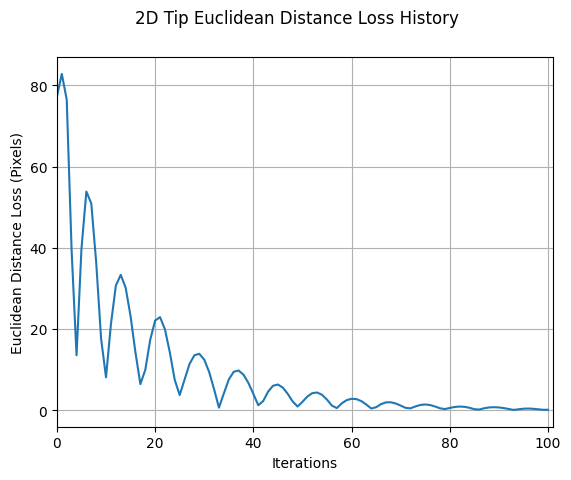

d3d_end_effector_loss_history:  [0.020112991333007812, 0.02690132148563862, 0.032561320811510086, 0.0321519710123539, 0.03338968753814697, 0.03697050362825394, 0.039321623742580414, 0.037616971880197525, 0.03313130512833595, 0.02751232497394085, 0.021965457126498222, 0.01746469922363758, 0.014415811747312546, 0.012387593276798725, 0.010723107494413853, 0.00917703565210104, 0.007829669862985611, 0.006870691664516926, 0.0064061894081532955, 0.006242969539016485, 0.005958085879683495, 0.005249334499239922, 0.0042508551850914955, 0.003847838845103979, 0.005050261504948139, 0.007313287816941738, 0.009819337166845798, 0.012160293757915497, 0.014125362038612366, 0.015596436336636543, 0.016532734036445618, 0.016984064131975174, 0.01709122024476528, 0.017054155468940735, 0.0170745849609375, 0.017300790175795555, 0.017803553491830826, 0.018583981320261955, 0.019589701667428017, 0.020730987191200256, 0.021904688328504562, 0.02302233874797821, 0.02402619644999504, 0.024887889623641968, 0.025597881

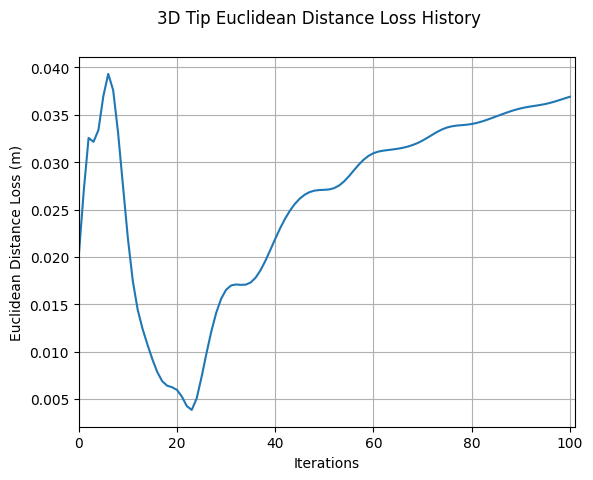

In [35]:
# Given array of values proj_end_effector_loss_history, create plot of loss vs. iterations
iterations_x_axis_proj = list(range(len(proj_end_effector_loss_history)))
print("proj_end_effector_loss_history: ", proj_end_effector_loss_history)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
fig1.suptitle('2D Tip Euclidean Distance Loss History')
ax1.plot(iterations_x_axis_proj, proj_end_effector_loss_history)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Euclidean Distance Loss (Pixels)')
ax1.set_xlim([0, len(proj_end_effector_loss_history)])
# ax1.set_ylim([0, 80])
ax1.grid(True)
plt.show()


# Given array of values d3d_end_effector_loss_history, create plot of 3d loss vs. iterations
iterations_x_axis_3d = list(range(len(d3d_end_effector_loss_history)))
print("d3d_end_effector_loss_history: ", d3d_end_effector_loss_history)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
fig2.suptitle('3D Tip Euclidean Distance Loss History')
ax2.plot(iterations_x_axis_3d, d3d_end_effector_loss_history)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Euclidean Distance Loss (m)')
ax2.set_xlim([0, len(d3d_end_effector_loss_history)])
# ax2.set_ylim([0, 0.05])
ax2.grid(True)
plt.show()